# Building a MNIST Convolutional Autoencoders in Keras
We'll start off by building a deep autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](autoencoder.png)


In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from sklearn import manifold

%matplotlib inline

Using TensorFlow backend.


## The Autoencoder

In [2]:
def create_autoencoder():
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    
    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    
    return autoencoder, encoder

In [3]:
autoencoder, encoder = create_autoencoder()
optimizer = Adadelta(lr=0.01)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

## Load the MNIST dataset

In [4]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


## Train the Autoencoder

In [ ]:
history = autoencoder.fit(
    x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 99s - loss: 0.6812 - val_loss: 0.6393

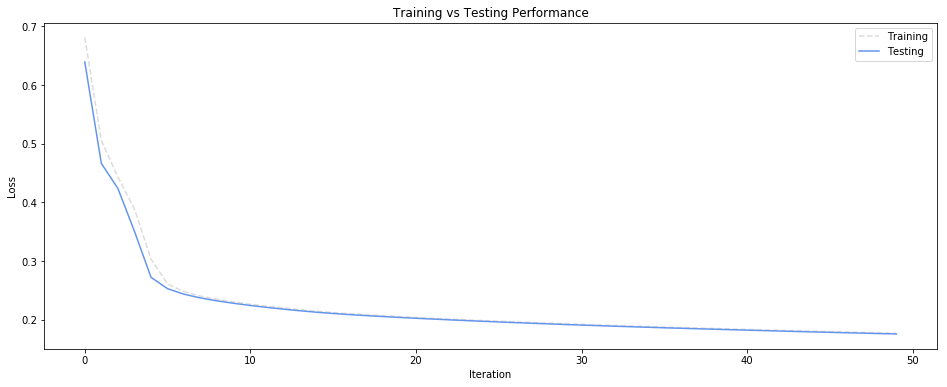

In [15]:
plt.figure(figsize=(16,6))
plt.title("Training vs Testing Performance")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt_train, = plt.plot(history.history['loss'], '--', color="gainsboro", label='Training')
plt_test, = plt.plot(history.history['val_loss'], color='cornflowerblue', label='Testing')
plt.legend(handles=[plt_train, plt_test])

## Checking out the performance

In [16]:
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs.shape

(10000, 28, 28, 1)

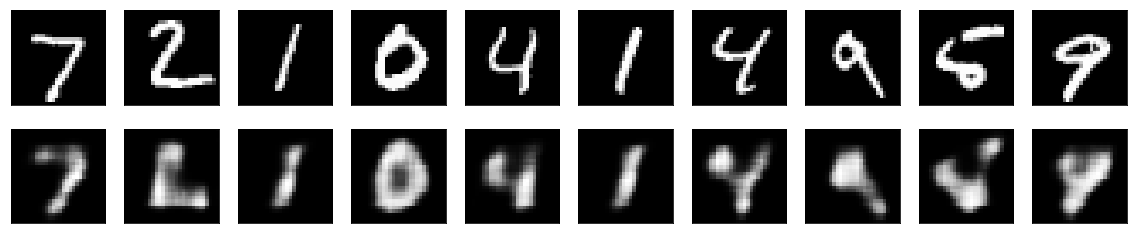

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Analyze the latent features

In [ ]:
embeddings = encoder.predict(x_test)
embeddings = embeddings.reshape(10000, 128)
embeddings.shape

### Manifold Learning methods: Isomap

In [18]:
Y2 = manifold.Isomap(3, 10).fit_transform(embeddings)

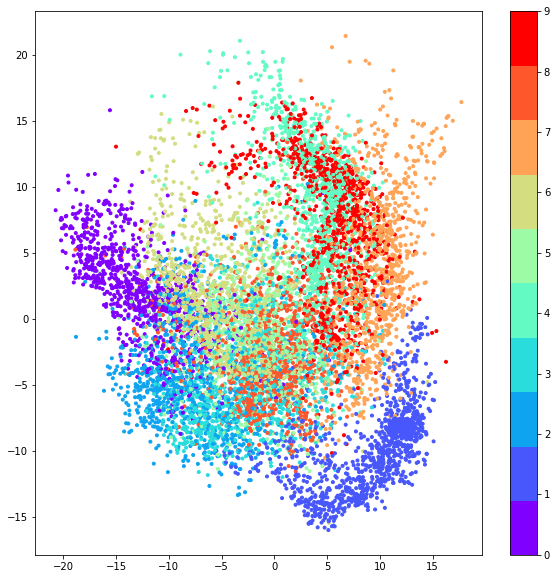

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(Y2[:, 0], Y2[:, 1], marker='.', c=y_test, cmap=plt.cm.get_cmap("rainbow", 10))
plt.colorbar()

## Deep Dive into the Learning
**Results after 10 Epochs:**
![](./conv_10_epochs.png)

**Results after 25 Epochs:**
![](./conv_25_epochs.png)

**Results after 50 Epochs:**
![](./conv_50_epochs.png)